# Costa Rican Household Poverty Level Prediction
## Arnaud Fournier and Tristan Mayer 

#### Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.
#### In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need. While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.
#### The problem we are going to try solving is improving the PMT by building another model based on the analysis of households characteristics. We will implement the different machine learning algorithms we have learned and select the best model according to cross validation performance.

In this notebook, we will walk through a complete machine learning solution: 
- perform a thorough Exploratory Data Analysis of the dataset
- work on feature engineering
- try out multiple machine learning models 
- select a model
- work to optimize the model
- inspect the outputs of the model 
- draw conclusions.


### Problem and Data Explanation
The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

### Objective
The objective is to predict poverty on a HOUSEHOLD level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we will have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

The Target values represent poverty levels as follows:

1 = extreme poverty

2 = moderate poverty 

3 = vulnerable households 

4 = non vulnerable households


### Metric
Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by Cross Validation Precision weighted average over the four categories.


## EDA
For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures).

In [94]:
# Data manipulation
import pandas as pd
import numpy as np

In [173]:
# Read in data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or ordinal variables with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

In [97]:
# Let's have a look at the distribution of unique values in the integer columns (how many colums have n distinct values?)
train.select_dtypes(np.int64).nunique().value_counts().sort_index() 

1       1
2     101
4       2
6       2
7       3
9       3
10      3
11      3
13      5
14      1
22      3
97      3
dtype: int64

There are 101 columns with only 2 unique values. It is very likely that those columns are filled with Booleans (0 or 1) and actually corresponds to the decomposition of categorical variables. For example, the columns sanitario1 to sanitario6 corresponds to the type of connection  the toilets (whether it is connected to sewer or cesspool, septic tank, black hole or letrine ...)

We can also notice that there is one columns that takes only one value, it will be useless for our analysis.

In [98]:
train.select_dtypes(np.int64).nunique().loc[lambda x : x==1]
train['elimbasu5'].isna().sum()

0

So the columns 'elimbasu5' which corresponds to '=1 if rubbish disposal mainly by throwing in river,  creek or sea" has only one unique value (0) for all individuals. It is therefore useless for our analysis. We will remove it in the Feature Engineering part.

In [99]:
# Now let's have a look at the 'objects' columns:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Id and idhogar are the way to identify the individuals and the households, we wil re-encode those columns later on for easier analysis.

The three other columns are:

- dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

For these three variables, "yes" = 1 and "no" = 0 so we will replace those values in the dataframe in the Feature Engineering section.

### Data Vizualisation

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Target variable distribution

Text(0.5,1,'Household Poverty Levels')

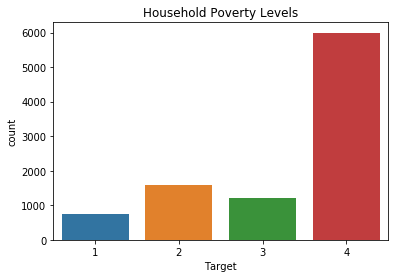

In [101]:
sns.countplot(x="Target", data=train).set_title('Household Poverty Levels')

#### What do households own?

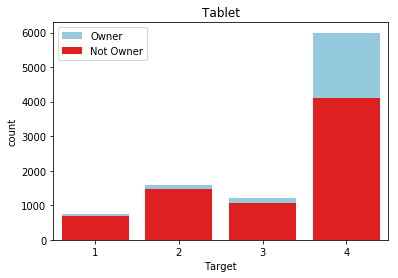

In [102]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['v18q']==0] , color="red", label="Not Owner").set_title('Tablet')
plt.legend()

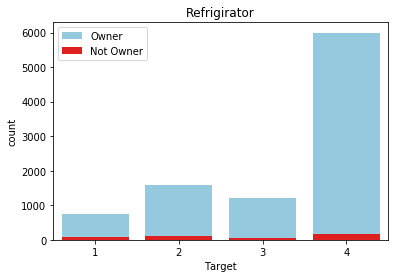

In [103]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['refrig']==0] , color="red",label="Not Owner").set_title('Refrigirator')
plt.legend()

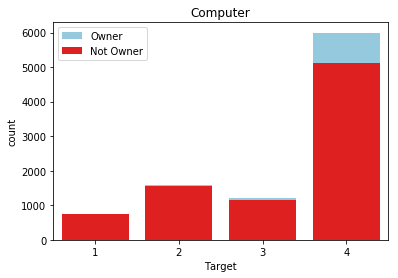

In [104]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['computer']==0] , color="red", label="Not Owner").set_title('Computer')
plt.legend()

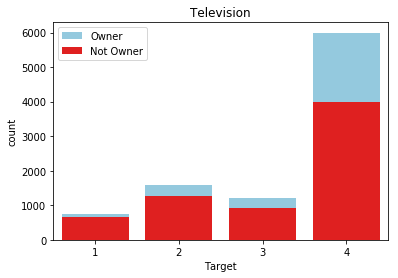

In [105]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['television']==0] , color="red", label="Not Owner").set_title('Television')
plt.legend()

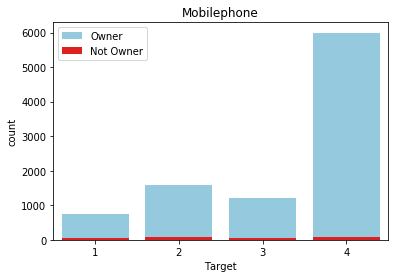

In [106]:
sns.countplot(train["Target"] , color="skyblue", label="Owner")
sns.countplot(train['Target'][train['mobilephone']==0] , color="red",label="Not Owner").set_title('Mobilephone')
plt.legend()

#### Key Characteristics of the Households

For the characteristics of the Households, we are going to have a look at the different set of columns that corresponds to the characteristics of special features of the households. Those features are:
- the wall material
- the floor material
- the roof material
- the sanitary conditions
- the cooking energy sources
- the disposal methods

In [107]:
def get_percentage_table(df):
    df = df.groupby('Target').sum().reset_index()
    df.iloc[:, 1:] = df.iloc[:, 1:].div(df.sum(axis=1), axis=0)*100
    df = df.round(2)
    return df.head(4)

In [108]:
# Outside Wall Material
df1 = train[['Target', 'paredblolad', 'paredpreb', 'paredmad', 'paredzocalo', 'pareddes', 'paredfibras', 'paredother', 'paredzinc']]
df1.columns = ['Target',"Block / Brick", "Cement", "Wood","Socket", "Waste Material","Fibres", "Other", "Zink"]
get_percentage_table(df1)


,Target,Block / Brick,Cement,Wood,Socket,Waste Material,Fibres,Other,Zink
0,1,39.02,24.74,20.37,10.71,1.59,0.26,0.00,3.17
1,2,38.09,24.52,20.45,11.32,2.63,0.44,0.31,2.13
2,3,51.16,23.27,14.36,9.74,0.91,0.00,0.00,0.33
3,4,69.22,15.60,7.50,6.05,0.28,0.08,0.15,1.05


In [109]:
# Floor Material
df2 = train[['Target' ,'pisomoscer', "pisocemento" , "pisonatur", "pisonotiene", "pisomadera", "pisoother"]]
df2.columns = ['Target', "Mosaic / Ceramic", "Cement",  "Natural Material", "No Floor",  "Wood","Other"]
get_percentage_table(df2)

,Target,Mosaic / Ceramic,Cement,Natural Material,No Floor,Wood,Other
0,1,46.56,37.70,0.13,4.37,11.11,0.00
1,2,49.34,35.08,0.56,3.88,11.01,0.00
2,3,60.89,27.56,0.00,1.90,9.41,0.00
3,4,79.03,15.83,0.00,0.65,4.27,0.15


In [110]:
# Roof Material
df3 = train[['Target','techozinc', "techoentrepiso", "techocane", "techootro"]]
df3.columns = ["Target","Zinc", "Fibre / Cement", "Natural Fibre", "Other"]
get_percentage_table(df3)

,Target,Zinc,Fibre / Cement,Natural Fibre,Other
0,1,97.32,1.61,0.94,0.00
1,2,97.69,1.67,0.51,0.00
2,3,99.09,0.41,0.25,0.00
3,4,97.28,2.10,0.20,0.35


In [111]:
# Sanitary Conditions
df4 = train[['Target','sanitario1', "sanitario2", "sanitario3", "sanitario5", "sanitario6"]]
df4.columns = ['Target', "No Toilet", "Sewer / Cesspool",  "Septic Tank", "Black Hole", "Other System"]
get_percentage_table(df4)

,Target,No Toilet,Sewer / Cesspool,Septic Tank,Black Hole,Other System
0,1,0.93,16.01,78.17,4.63,0.13
1,2,0.75,17.39,78.17,2.94,0.63
2,3,0.74,12.95,83.50,2.56,0.00
3,4,0.15,24.82,74.18,0.57,0.22


In [112]:
# Cooking Energy Source
df5 = train[['Target','energcocinar1', "energcocinar2", "energcocinar3","energcocinar4"]]
df5.columns = ['Target', "No Kitchen", "Electricity", "Cooking Gas","Wood Charcoal"]
get_percentage_table(df5)

,Target,No Kitchen,Electricity,Cooking Gas,Wood Charcoal
0,1,0.93,32.54,53.44,12.96
1,2,0.19,38.96,51.28,9.44
2,3,0.25,43.40,49.50,6.60
3,4,0.08,54.73,42.62,2.50


In [113]:
# Disposal Methods
df6 = train[['Target', "elimbasu1", "elimbasu2", "elimbasu3", "elimbasu4", "elimbasu6"]]
df6.columns = ['Target', "Tanker truck","Buried","Burning","Unoccupied space","Other"]
get_percentage_table(df6)

,Target,Tanker truck,Buried,Burning,Unoccupied space,Other
0,1,80.03,4.63,15.21,0.00,0.0
1,2,80.18,5.13,13.88,0.69,0.0
2,3,83.33,3.55,12.62,0.25,0.0
3,4,92.32,2.12,5.30,0.00,0.2


Let's take a look at how rooms are distributed by poverty level. Since this is individual level data, not household level, we'll first need to group by the household id 'idhogar', otherwise, we will be double-counting.

Text(0.5,0,'Number of rooms')

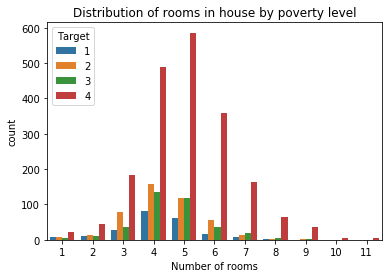

In [114]:
sns.countplot(x='rooms', hue='Target', data= train.groupby('idhogar')['Target', 'rooms'].first())
plt.title('Distribution of rooms in house by poverty level')
plt.xlabel('Number of rooms')

#### Monthly Rent Payment

Let's look at the feature 'v2a1' or monthly rent payment. How is monthly rent distributed among the four poverty levels? Due to the presence of a possible outlier in in monthly rent payment, the box plots get squeezed. I have plotted them without the outliers.

Text(0,0.5,'Monthyl rent payment')

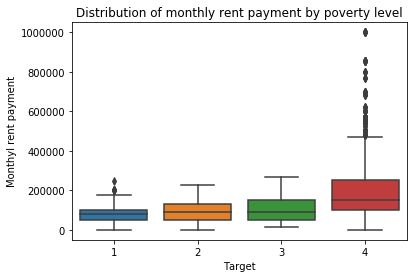

In [115]:
sns.boxplot(x='Target', y='v2a1', data=train[train.v2a1 < 2000000])
plt.title('Distribution of monthly rent payment by poverty level')
plt.ylabel('Monthyl rent payment')

### Head of Household Variable
This is actually the train set we are going to work on which is very similar to the entire dataset.

Text(0.5,1,'Household Poverty Levels')

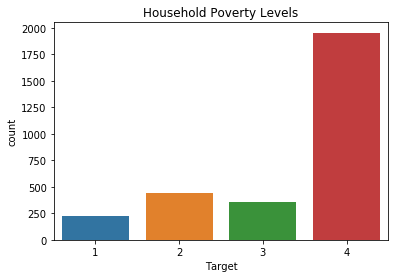

In [116]:
sns.countplot(x="Target", data=train[train.parentesco1== 1]).set_title('Household Poverty Levels')

#### Important points to notice from this EDA:
- there are a lot of columns and they can be regrouped in different categories
- concerning the distributions of the few categories we have ploted or described, we observe relatively intuitive characteristics: poorest households have worse materials for their houses, they own less technological devices, basics needs in terms of infrastructures are rarely met. 
- the monthly rent payment for the three poorest categories of households are very similar therefore it cannot be a precice indicator of the poverty level although it would have appeared as a good proxi.

However, the goal of all this work is to define a classifying algorithm that will set the best thresholds to define if a housholds belong to which of the four poverity level categories, therefore, other more statistically useable characteristics need to be found and a model need to be fitted. This is what we are going to do in the next sections.

#### Things to do in the next section (feature engineering):
- create categories of features
- remove the column 'elimbasu5'
- re-encode the columns 'Id' and 'idhogar'
- re-encode the columns 'dependency', 'edjefe' and 'edjefa'
- fix inconsitencies between variables that are very similar (for example
- VERY IMPORTANT: as we are asked to do the analysis on households and not on individuals, the best proxi we are going to use is the head of households (when parentesco1==1). This is what is indicated in the rules of the competition so we will get rid of all rows (individuals) that do not meet this criteria. 


#### things to take into account for model building:
- Oversampling or undersampling of different class to manage imbalances

## Feature engineering

In [117]:
def feature_creation_function(df):
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('bed_density', 'bedrooms', 'rooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('person_per_room', 'r4t3', 'rooms'),
                 ('person_per_room', 'r4t3', 'bedrooms'),
                 ('rez_esc_escolari', 'rez_esc', 'escolari'),
                 ('rez_esc_r4t1', 'rez_esc', 'r4t1'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2'),
                 ('male_over_female', 'r4h3', 'r4m3'),
                 ('man12plus_over_women12plus', 'r4h2', 'r4m2'),
                 ('pesioner_over_working', 'hogar_mayor', 'hogar_adul'),
                 ('children_over_working', 'hogar_nin', 'hogar_adul'),
                 ('education_fraction', 'escolari', 'age')
                 #('', '', ''),
                ]
    
    
  
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('non_bedrooms', 'rooms', 'bedrooms'),
                 ('people_not_linving_', 'tamhog', 'r4t3')
                 ]

    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32).replace(np.inf, 0)       
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32).replace(np.inf, 0)
        
    df['edjef'] = np.max(df[['edjefa','edjefe']], axis=1).replace({"yes": 1, "no": 0}).astype(np.float64)
    
    


In [118]:

from sklearn.preprocessing import LabelEncoder

def preprocess(df): #reencode idhogar
    # encode the idhogar - houshold level identifier
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])
    

In [119]:
def clean_column(df):
    #mapping yes/no to float values
    df['dependency'] = df['dependency'].replace({"yes": 1, "no": 0}).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace({"yes": 1, "no": 0}).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace({"yes": 1, "no": 0}).astype(np.float64)
    #Some rows indicate that household have and don't have toilets - we fix the inconsistency by setting 0 if they have no water
    df.loc[(df.v14a ==  1) & (df.sanitario1 ==  1) & (df.abastaguano == 0), "v14a"] = 0
    df.loc[(df.v14a ==  1) & (df.sanitario1 ==  1) & (df.abastaguano == 0), "sanitario1"] = 0
    #'v18q1' only missing when 'v18q' is 0 So will fill with 0 
    df['v18q1']=df['v18q1'].fillna(0)
    # As discussed in https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403#, missing values or rent payment can be interpreted as 0 payment
    df['v2a1']=df['v2a1'].fillna(0)
    #We are missing most of missing years in school, it seems like this column was not filled in much in the survey, we will drop the column
    df['rez_esc']=df['rez_esc'].fillna(0)
    #Same goes here, we have only 31 missing values for the whole test set and 0 for the train set. We just impute them with 0 rther than using a more complicated methods for now
    df['meaneduc']=df['meaneduc'].fillna(0)
    df['SQBmeaned']=df['SQBmeaned'].fillna(0)

In [120]:
def recoding_ordinal(df):  #create ordinal variable instead of OHE   
    df['walls'] = np.argmax(np.array(df[['epared1', 'epared2', 'epared3']]), axis = 1) #Get quality indexes
    df['roof'] = np.argmax(np.array(df[['etecho1', 'etecho2', 'etecho3']]), axis = 1)
    df['floor'] = np.argmax(np.array(df[['eviv1', 'eviv2', 'eviv3']]), axis = 1)
    df['house_qual']= df['walls'] + df['roof'] + df['floor']
    
    power =[]
    for i, row in df.iterrows():
        if row['noelec'] == 1:
            power.append(0)
        elif row['coopele'] == 1:
            power.append(1)
        elif row['public'] == 1:
            power.append(2)
        elif row['planpri'] == 1:
            power.append(3)
        else:
            power.append(np.nan)
            
    df['power'] = power
    df['power-missing'] = df['power'].isnull()  
    df['danger'] = 1 * (df['sanitario1'] + (df['power'] == 0) + df['pisonotiene'] + df['abastaguano'] + (df['cielorazo'] == 0))     


In [121]:
def agg_function_household(df): #create a lot of features
    
    list_aggr_mean = ['rez_esc', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco2',
             'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12',
             'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',]

    list_other = ['escolari', 'age', 'fe_education_fraction']

    df_2 = pd.DataFrame()
    
    for item in list_aggr_mean:
        group_mean = df[item].groupby(df['idhogar']).mean()
        new_col = item + '_aggr_MEAN'
        df_2[new_col] = group_mean
        

    for item in list_other:
        for function in ['mean','std','min','max','sum']:
            group = df[item].groupby(df['idhogar']).agg(function)
            new_col = item + '_' + function.upper()
            df_2[new_col] = group
            
            
    df_2 = df_2.reset_index()
    df = pd.merge(df, df_2, on = 'idhogar')
    df.fillna(value=0, inplace=True) 
    return df
   


#not working and clearly doesnt make sense to me ...
from sklearn.preprocessing import LabelEncoder

for elem in [train, test]:
    feature_creation_function(elem)
    preprocess(elem) #reencode idhogar
    clean_column(elem)
    recoding_ordinal(elem)
    elem = agg_function_household(elem)
    clean_column(elem)

In [122]:

#Apply to Train
preprocess(train)
feature_creation_function(train)
clean_column(train)
recoding_ordinal(train)
train = agg_function_household(train)


#Apply to test
preprocess(test)
feature_creation_function(test)
clean_column(test)
recoding_ordinal(test)
test = agg_function_household(test)
test = test.query('parentesco1==1')
test_id= test['Id']

## Feature selection

In [123]:
#Feature correlation with Target ranknig - We see that some feature we have re-ingeneered are working great ! 
train.corr()['Target'].map(lambda x: abs(x)).sort_values(ascending = False)

Target                       1.000000
escolari_MEAN                0.449353
escolari_MAX                 0.388633
fe_children_over_working     0.376578
meaneduc                     0.333932
house_qual                   0.329522
hogar_nin                    0.328199
r4t1                         0.316745
SQBhogar_nin                 0.311186
danger                       0.310006
instlevel8_aggr_MEAN         0.306825
walls                        0.306293
escolari_MIN                 0.305241
cielorazo                    0.304421
floor                        0.303165
escolari                     0.302305
fe_mobile_density            0.301448
SQBescolari                  0.296577
eviv3                        0.294222
epared3                      0.292451
fe_children_fraction         0.290035
fe_human_bed_density         0.289110
overcrowding                 0.289110
fe_person_per_room           0.282458
pisomoscer                   0.280284
instlevel1_aggr_MEAN         0.278413
SQBmeaned   

In [124]:
#To improve our variance estimator, we want to delete highly correlated feature - We choose a 0.95 threshold above wich we delete the feature
corr_matrix = train.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
print(to_drop)

['tamhog', 'hhsize', 'coopele', 'female', 'hogar_total', 'area2', 'SQBage', 'SQBhogar_total', 'agesq', 'fe_human_bed_density', 'fe_person_per_room', 'power', 'male_aggr_MEAN', 'female_aggr_MEAN']


In [125]:
def drop_var(df):
    df.drop(['tamhog', 'hhsize', 'coopele', 'female', 'hogar_total', 'area2', 'SQBage', 'SQBhogar_total', 'agesq', 'fe_human_bed_density', 'fe_person_per_room', 'power', 'male_aggr_MEAN', 'female_aggr_MEAN'],axis=1, inplace=True)
#Column wth more than 0.95% corr to any other column 
    df.drop(['Id'],axis=1, inplace=True) # column with obj type
    df.drop(['elimbasu5','noelec', 'public', 'planpri', 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3'],axis=1, inplace=True)
#column we have re-ingeneered


In [168]:
#dropping variables
drop_var(train)
drop_var(test)

In [127]:
X = train.query('parentesco1==1')

# pull out the target variable
y = X['Target'] - 1 # this is done to bing input labels [1,2,3,4] in agreement with lightgbm [0,1,2,3]
X = X.drop(['Target'], axis=1)

We also want to get a sense fo the most important feature in the dataset. so we fit a quick and dirty GBM Classifier to get the feature importance - We will use these results in the fonction drop_var to drop variable woth almost 0 importance

In [128]:
from sklearn.ensemble import GradientBoostingClassifier

In [129]:
gbm = GradientBoostingClassifier(n_estimators=100).fit(X,y)

In [ ]:
#Problem with this one ! 
featur_imp = pd.DataFrame({
    'importance':gbm.feature_importances_.round(5)
}, index=train.columns)

featur_imp.sort_values('importance', ascending=False, inplace=True)

featur_imp.iloc[1:30, ].plot.bar(legend=None, figsize=(17,5));
plt.title('Feature Importance');

## Model building

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic regression Classifier

In [132]:
from sklearn.linear_model import LogisticRegression

In [133]:
lr = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', class_weight='balanced', random_state = 0)
p_lr = {"C":np.logspace(-3,3,7)}
lr_gridsr = GridSearchCV(lr, p_lr, cv=5)
lr_gridsr.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", 

/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [134]:
pred_lr = lr_gridsr.predict(X_test)

In [135]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.24      0.44      0.31        50
           1       0.30      0.26      0.28        93
           2       0.21      0.45      0.29        64
           3       0.90      0.66      0.76       388

   micro avg       0.56      0.56      0.56       595
   macro avg       0.41      0.45      0.41       595
weighted avg       0.68      0.56      0.60       595



#### Results from the logistic regression classifier:

We get an average cross validation precision of 0.66 which means that around 66% of the time this model will correctly classify the household in the right poverty level. This is not optimal and other models might achieve a bettre precision. Logistic regression is the most naive model and gives a benchmark of the lowest bound that a model should get. It is a simple and robust model with little to no hyperparameters to tune. 

In this case, we have tested few different flavors of logistic regression: 
- Basic Logit
- L1 and L2 penalisation
- Balanced and unbalanced sample 

After comparaison of the results we have achived the highest performance with the L2 penalisation for a lambda value of ........................??????????? and using a balanced dataset
We aim to use more complex models and use logistic regression as a baseline for comparation. 

The model weighted accuracy cross validation score is XXX
Tested on the kaggle test set we have achived XXX

### Random forest classifier

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
rf = RandomForestClassifier(class_weight='balanced')
p_rf = {'n_estimators': list(range(30,180, 1))}
rf_gridsr = GridSearchCV(rf, p_rf, cv=5)
rf_gridsr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,...160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]},
       pre_dispatch='2*n_jobs', ref

In [138]:
pred_rf = rf_gridsr.predict(X_test)

In [139]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.67      0.16      0.26        50
           1       0.29      0.11      0.16        93
           2       0.12      0.02      0.03        64
           3       0.69      0.96      0.80       388

   micro avg       0.66      0.66      0.66       595
   macro avg       0.44      0.31      0.31       595
weighted avg       0.56      0.66      0.57       595



Comparing this model with the logistic regression baseline ..




The model weighted accuracy cross validation score is XXX
Tested on the kaggle test set we have achived XXX

### Light Gradient Boosting Method

In [141]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [142]:
param_test ={'num_leaves': sp_randint(12, 20), 
             'min_child_samples': sp_randint(40, 100), 
             'subsample': sp_uniform(loc=0.75, scale=0.25), 
             'colsample_bytree': sp_uniform(loc=0.8, scale=0.15)
            }

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

LGBM_ = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.05, objective='multiclass',
                         random_state=314, silent=True, metric='None', 
                         n_jobs=4, n_estimators=5000, class_weight='balanced')

In [143]:
RandSr = RandomizedSearchCV(
    estimator= LGBM_, param_distributions=param_test, 
    n_iter= n_HP_points_to_test,
    scoring='f1_macro',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)
#Why use F1-Macro ?

In [144]:
fit_LGBM = RandSr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 197.8min finished


In [181]:
print(fit_LGBM)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
        max_depth=-1, metric='None', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=31, objective='multiclass', random_state=314,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f30aa9522b0>, 'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f30aa952400>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f30aa952588>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f30aa952c18>},
        

In [145]:
pred_lgbm = fit_LGBM.predict(X_test)

In [176]:
test_predictions = fit_LGBM.predict(test)
test_predictions_rf = rf_gridsr.predict(test)
test_prediction_lr = lr_gridsr.predict(test)

ValueError: Number of features of the model must match the input. Model n_features_ is 191 and input n_features is 219 

In [177]:
submit_lgbm = pd.DataFrame({'Id': test_id, 'Target': test_predictions + 1})
submit_rf = pd.DataFrame({'Id': test_id, 'Target': test_predictions_rf + 1})
submit_lr = pd.DataFrame({'Id': test_id, 'Target': test_prediction_lr + 1})

In [180]:
#Graveyard
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(submit_lgbm)
create_download_link(submit_rf)
create_download_link(submit_lr)

In [162]:
submit_lgbm.to_csv('submission_lgbm.csv', index=False)
submit_rf.to_csv('submission_rf.csv', index=False)
submit_lr.to_csv('submission_lr.csv', index=False)



In [146]:
print(classification_report(y_test, pred_lgbm))

              precision    recall  f1-score   support

           0       0.32      0.12      0.17        50
           1       0.32      0.30      0.31        93
           2       0.22      0.17      0.19        64
           3       0.75      0.85      0.80       388

   micro avg       0.63      0.63      0.63       595
   macro avg       0.40      0.36      0.37       595
weighted avg       0.59      0.63      0.60       595



The LGBM model usually showcase great performance but need much more careful tuning than random forest models.

We have used a randomized search, which has run for XX hours. The randomized search approach allows for more efficient tuning, requiring less power for computation. Considering the amoung of hyperparameters to tune we had no other choice. We however decided to use a high number of random Hyperparameters points at every fit, which we believe has helped achive a decent accuracy with respect to the model potential.

The model weighted accuracy cross validation score is XXX
Tested on the kaggle test set we have achived XXX

## Conclusions

### On the Data

The dataset we were provided with was quite complete (very few missing values) and large but the task that was asked contrained us to not make use of all the observations when fitting our models. Dismissing all the individuals that were not heads of houshold considerably reduced the amount of data points on which we were able to fit the models. 
We were however able to use household-level aggregates as features in the model (for instance min, max & avg schooling years of household members). 

As to be expected with survey data, we faced quite a few inconsistencies. Some household were recorded as having and not havong toilets, some household did not have head of households. As describe in this notebook we found ways to make assumptions and go over these problems.

One important question to raise as well is how were the different levels of poverty established in the first place? One easy answer when we talk about poverty levels is to think in terms of revenue/wage/salary/$ per day. 

Lastly, the optimisation metric of our algorithm is currentyl F1-score (hence, enqually weighting accuracy and recall) but after review of financial implication of the new method it may be necessary to take different measures as opportnity cost could be different.

### On the Model

### Competition

using the techniques we highlighted above, we managed to rank as high as XX and score in the top X% of the competition on Kaggle.

## Kaggle Submission